# Classify Building Conditions in Zanzibar from Drone Imagery

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.7.0
fastai        : 1.0.39
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 410.78
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16278MB | Quadro P5000

=== Environment === 
platform      : Linux-4.4.0-104-generic-x86_64-with-debian-stretch-sid
distro        : #127-Ubuntu SMP Mon Dec 11 12:16:42 UTC 2017
conda env     : fastai-v1
python        : /home/paperspace/anaconda3/envs/fastai-v1/bin/python
sys.path      : /home/paperspace/fastai/course-v3/nbs/dl1/dave-nbs-fastai-p1v3
/home/paperspace/anaconda3/envs/fastai-v1/lib/python37.zip
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/lib-dynload

/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/site-packages
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/IPython/extensions
/home/paperspace/.ipy

## Prepare Data

In [4]:
path = Path('data/znz-classify')

In [5]:
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

20176


[PosixPath('data/znz-classify/images/grid035_00560_Complete.jpg'),
 PosixPath('data/znz-classify/images/grid042_00289_Complete.jpg'),
 PosixPath('data/znz-classify/images/grid051_02480_Empty.jpg'),
 PosixPath('data/znz-classify/images/grid001_00317_Complete.jpg'),
 PosixPath('data/znz-classify/images/grid043_00677_Complete.jpg')]

In [7]:
# filter out empty jpg files by size>0 and sort
fnames = [fname.name for fname in sorted(fnames) if os.path.getsize(fname)>0]
print(len(fnames))
fnames[:5]

20176


['grid001_00001_Complete.jpg',
 'grid001_00002_Complete.jpg',
 'grid001_00003_Complete.jpg',
 'grid001_00004_Complete.jpg',
 'grid001_00005_Complete.jpg']

In [8]:
df = pd.DataFrame(fnames,columns=['fnames'])
df.head()

fnames
0  grid001_00001_Complete.jpg
1  grid001_00002_Complete.jpg
2  grid001_00003_Complete.jpg
3  grid001_00004_Complete.jpg
4  grid001_00005_Complete.jpg

In [9]:
# hand-picked val grids
holdout_grids = ['grid028_','grid029_','grid042_','grid058_']
valid_idx = [i for i,o in df.iterrows() if any(c in str(o.fnames) for c in holdout_grids)]

In [10]:
df.iloc[valid_idx].head()

fnames
7432     grid028_00000_Empty.jpg
7433  grid028_00001_Complete.jpg
7434  grid028_00002_Complete.jpg
7435  grid028_00003_Complete.jpg
7436  grid028_00004_Complete.jpg

In [11]:
# pulled out of fastai/data.py
pat = r'([^_]+).jpg$'
pat = re.compile(pat)
def get_label(fn): return pat.search(str(fn)).group(1)

In [12]:
src = (ImageItemList.from_df(df, folder='images', path=path)
        .split_by_idx(valid_idx)
        .label_from_func(get_label, classes=['Complete', 'Incomplete', 'Foundation', 'Empty']))

In [13]:
bs = 32
sz = 512
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)
data = (src.transform(tfms, size=512, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [14]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (14833 items)
[Category Complete, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: data/znz-classify
x: ImageItemList (14833 items)
[Image (3, 428, 920), Image (3, 184, 187), Image (3, 197, 196), Image (3, 157, 157), Image (3, 185, 188)]...
Path: data/znz-classify;

Valid: LabelList
y: CategoryList (5343 items)
[Category Empty, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: data/znz-classify
x: ImageItemList (5343 items)
[Image (3, 243, 179), Image (3, 298, 234), Image (3, 186, 221), Image (3, 300, 181), Image (3, 176, 184)]...
Path: data/znz-classify;

Test: None

In [15]:
data.train_ds.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

Empty data/znz-classify/images/grid028_00000_Empty.jpg


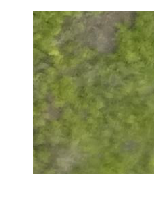

Complete data/znz-classify/images/grid028_00001_Complete.jpg


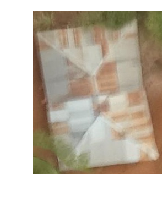

Complete data/znz-classify/images/grid028_00002_Complete.jpg


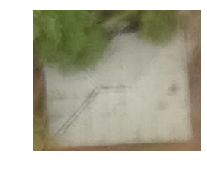

Complete data/znz-classify/images/grid028_00003_Complete.jpg


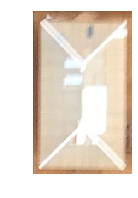

Complete data/znz-classify/images/grid028_00004_Complete.jpg


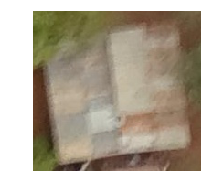

In [16]:
for i in range(5):
    print(data.valid_ds.classes[data.valid_ds.y[i].data], data.valid_ds.items[i]); 
    data.valid_ds.x[i].show()
    plt.show()

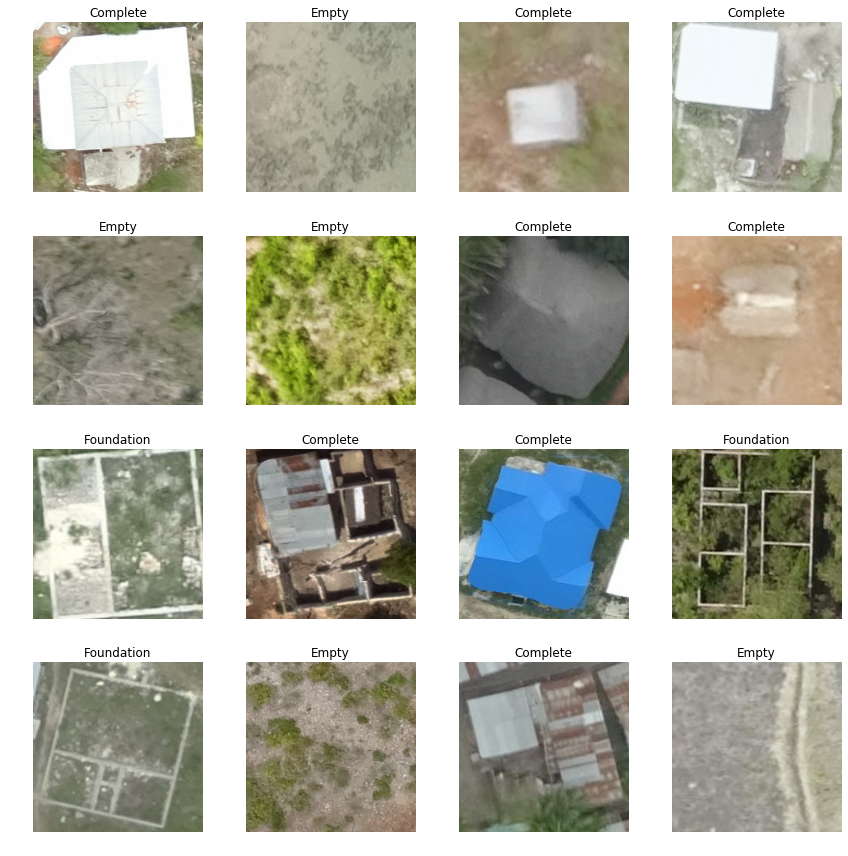

In [17]:
data.show_batch(rows=4, figsize=(12,12))

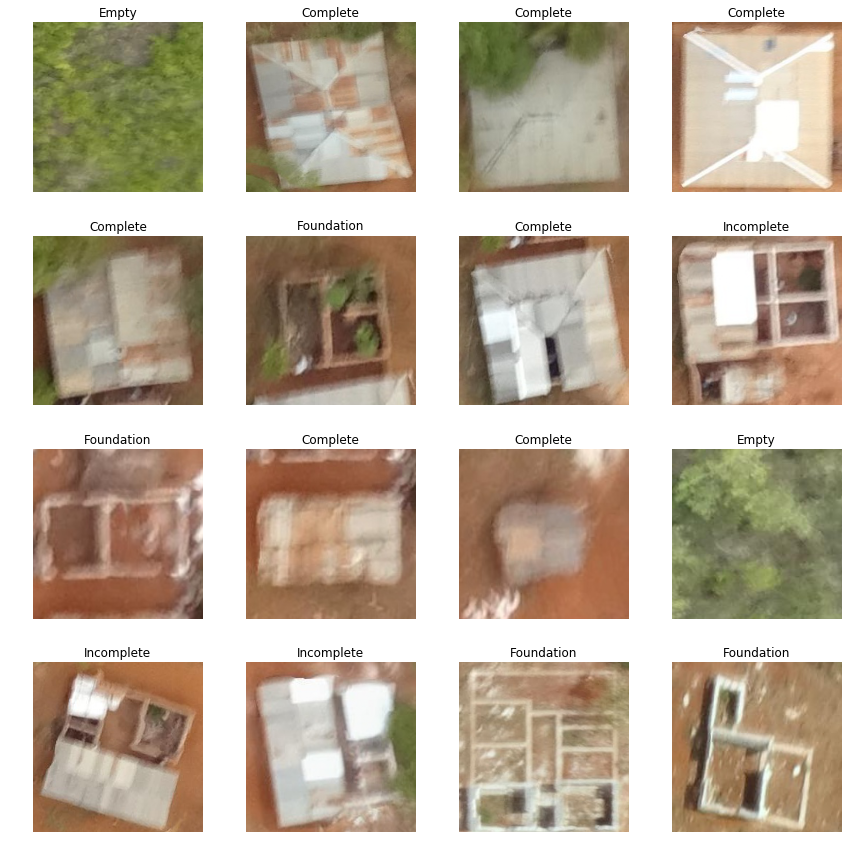

In [18]:
data.show_batch(rows=4, figsize=(12,12), ds_type=DatasetType.Valid)

In [19]:
data.loss_func

## Train with ResNet50

In [20]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


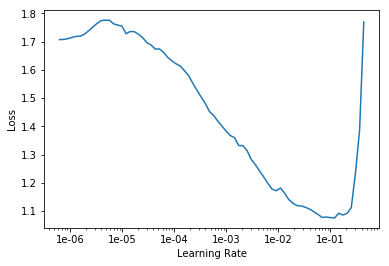

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
lr = 1e-2

In [40]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [41]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name='20190107-rn50class-stage1-best')
                    ]
                   )

saved model at epoch 1 with error_rate value: 0.11061201244592667
saved model at epoch 2 with error_rate value: 0.07842036336660385
saved model at epoch 6 with error_rate value: 0.06850083917379379
saved model at epoch 8 with error_rate value: 0.06082725152373314


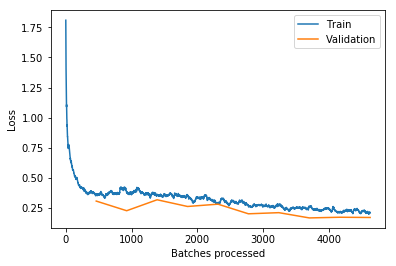

In [42]:
learn.recorder.plot_losses()

## Look at Results

In [21]:
learn.load('20190107-rn50class-stage1-best')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (14833 items)
[Category Complete, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: data/znz-classify
x: ImageItemList (14833 items)
[Image (3, 428, 920), Image (3, 184, 187), Image (3, 197, 196), Image (3, 157, 157), Image (3, 185, 188)]...
Path: data/znz-classify;

Valid: LabelList
y: CategoryList (5343 items)
[Category Empty, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: data/znz-classify
x: ImageItemList (5343 items)
[Image (3, 243, 179), Image (3, 298, 234), Image (3, 186, 221), Image (3, 300, 181), Image (3, 176, 184)]...
Path: data/znz-classify;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, d

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

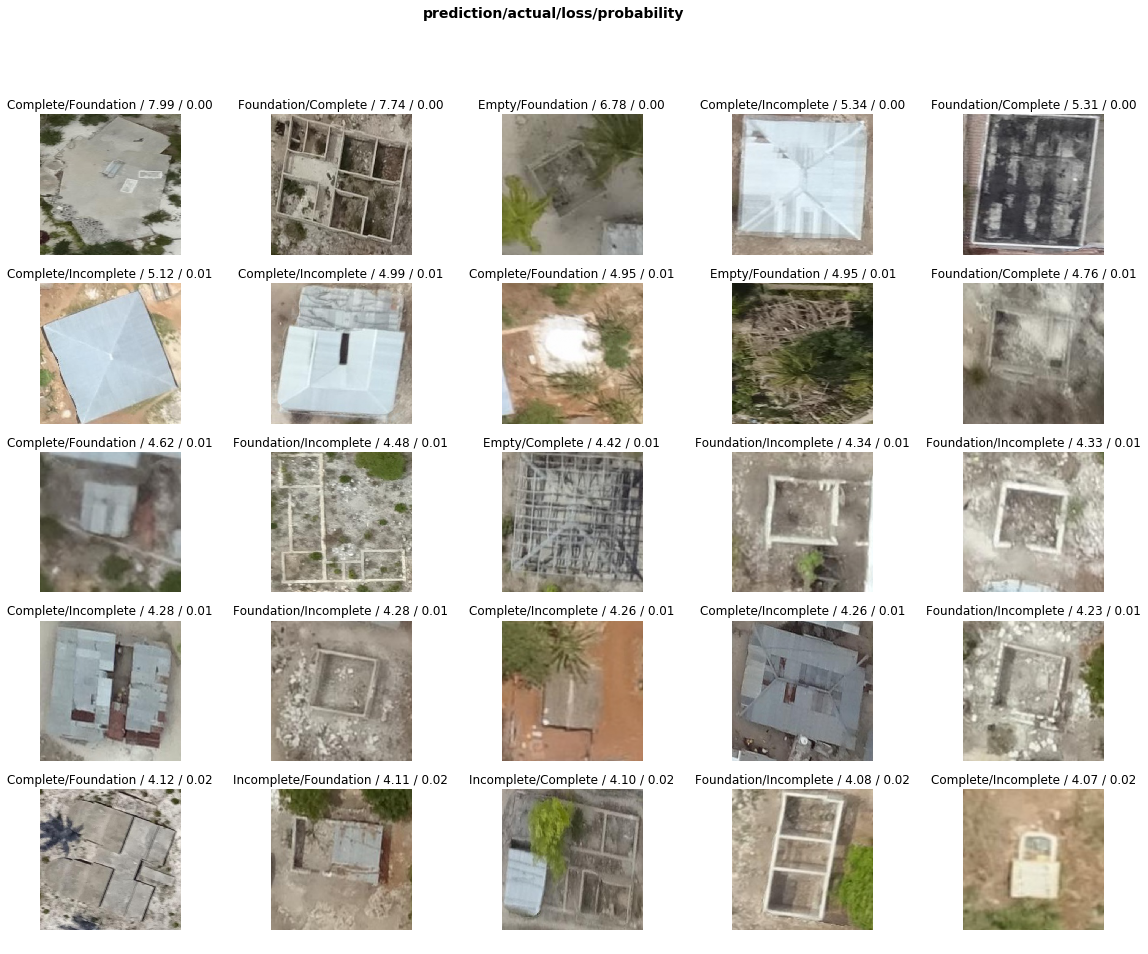

In [23]:
interp.plot_top_losses(25, figsize=(20,15))

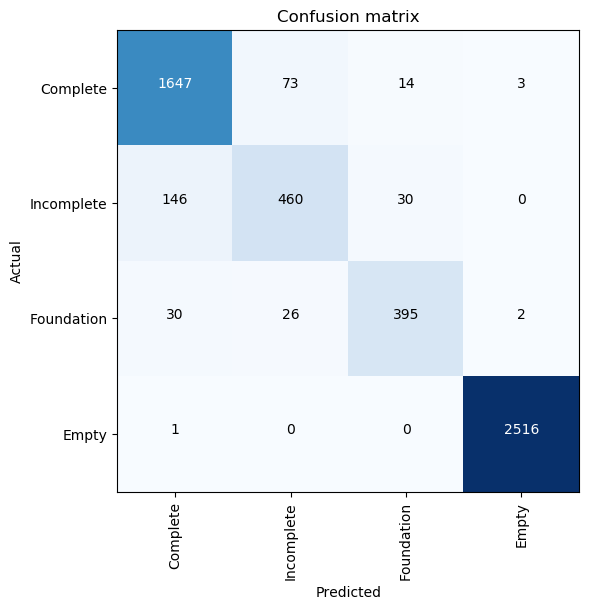

In [26]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [27]:
interp.most_confused(min_val=2)

[('Incomplete', 'Complete', 146),
 ('Complete', 'Incomplete', 73),
 ('Incomplete', 'Foundation', 30),
 ('Foundation', 'Complete', 30),
 ('Foundation', 'Incomplete', 26),
 ('Complete', 'Foundation', 14),
 ('Complete', 'Empty', 3)]

## Test time

In [21]:
data.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

In [22]:
learn.load('20190107-rn50class-stage1-best')
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [23]:
grid_num = '042'
test_path = Path(f'data/znz-20190118-classify/test_{grid_num}')
test_fns = [o for o in sorted(test_path.iterdir()) if '.jpg' in o.name]
print(len(test_fns))

554


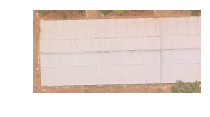

In [24]:
img = open_image(test_fns[100])
img.show()
plt.show()

In [25]:
learn.predict(img)

(Category Complete,
 tensor(0),
 tensor([9.9428e-01, 5.2332e-03, 4.2482e-04, 6.2749e-05]))

In [26]:
from tqdm import tqdm

In [27]:
preds = []
pred_classes = []
for fn in tqdm(test_fns):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

100%|██████████| 554/554 [00:17<00:00, 31.05it/s]


In [28]:
np.round(preds,2)

array([[0.98, 0.02, 0.  , 0.  ],
       [0.62, 0.37, 0.01, 0.  ],
       [0.95, 0.04, 0.01, 0.  ],
       [0.97, 0.01, 0.02, 0.  ],
       ...,
       [0.99, 0.01, 0.  , 0.  ],
       [0.86, 0.14, 0.  , 0.  ],
       [0.89, 0.1 , 0.01, 0.  ],
       [0.98, 0.02, 0.  , 0.  ]], dtype=float32)

In [29]:
df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [o.name for o in test_fns[:len(preds)]]
df['predicted_class'] = pred_classes

In [30]:
df.head(25)

Complete  Incomplete  Foundation     Empty               fname  \
0   0.976538    0.018455    0.004929  0.000078  042_00000_test.jpg   
1   0.622820    0.366870    0.009612  0.000699  042_00001_test.jpg   
2   0.952509    0.040787    0.006185  0.000519  042_00002_test.jpg   
3   0.972964    0.007936    0.018866  0.000234  042_00003_test.jpg   
4   0.028022    0.103362    0.867339  0.001277  042_00004_test.jpg   
5   0.925937    0.062759    0.009938  0.001366  042_00005_test.jpg   
6   0.899388    0.068044    0.031874  0.000694  042_00006_test.jpg   
7   0.002626    0.017426    0.979867  0.000081  042_00007_test.jpg   
8   0.940906    0.033005    0.026014  0.000075  042_00008_test.jpg   
9   0.000327    0.012275    0.987243  0.000156  042_00009_test.jpg   
10  0.052122    0.904228    0.043574  0.000076  042_00010_test.jpg   
11  0.992851    0.005937    0.001190  0.000021  042_00011_test.jpg   
12  0.962532    0.033595    0.003788  0.000086  042_00012_test.jpg   
13  0.056311    0.000402    0.000297  0.942991  042_00013_test.jpg   
14  0.965136    0.031845    0.002981  0.000038  042_00014_test.jpg   
15  0.060953    0.093895    0.844790  0.000362  042_00015_test.jpg   
16  0.006211    0.055688    0.937621  0.000480  042_00016_test.jpg   
17  0.002097    0.013625    0.984236  0.000042  042_00017_test.jpg   
18  0.321659    0.675192    0.003114  0.000036  042_00018_test.jpg   
19  0.971601    0.019344    0.008995  0.000060  042_00019_test.jpg   
20  0.025230    0.937457    0.037242  0.000070  042_00020_test.jpg   
21  0.976390    0.016901    0.005842  0.000867  042_00021_test.jpg   
22  0.957896    0.021974    0.019933  0.000198  042_00022_test.jpg   
23  0.035010    0.957815    0.007143  0.000031  042_00023_test.jpg   
24  0.054932    0.923368    0.021627  0.000072  042_00024_test.jpg   

   predicted_class  
0         Complete  
1         Complete  
2         Complete  
3         Complete  
4       Foundation  
5         Complete  
6         Complete  
7       Foundation  
8         Complete  
9       Foundation  
10      Incomplete  
11        Complete  
12        Complete  
13           Empty  
14        Complete  
15      Foundation  
16      Foundation  
17      Foundation  
18      Incomplete  
19        Complete  
20      Incomplete  
21        Complete  
22        Complete  
23      Incomplete  
24      Incomplete

In [31]:
pred_classes[:5]

['Complete', 'Complete', 'Complete', 'Complete', 'Foundation']

Complete category confidence: 0.9765382409095764


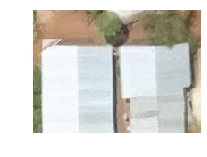

Complete category confidence: 0.6228196620941162


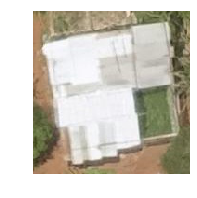

Complete category confidence: 0.9525092244148254


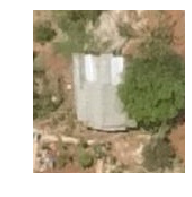

Complete category confidence: 0.9729635715484619


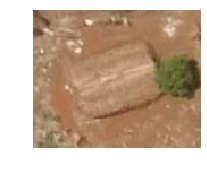

Foundation category confidence: 0.8673386573791504


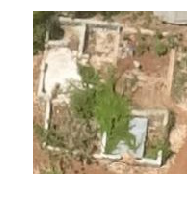

Complete category confidence: 0.9259365200996399


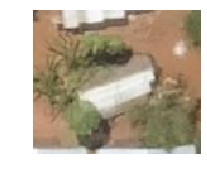

Complete category confidence: 0.8993884921073914


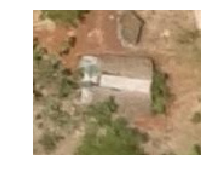

Foundation category confidence: 0.9798665046691895


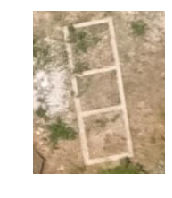

Complete category confidence: 0.9409058094024658


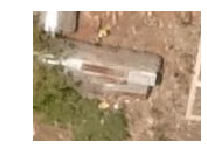

Foundation category confidence: 0.9872429370880127


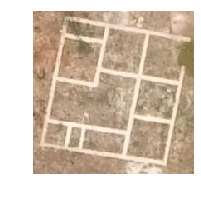

Incomplete category confidence: 0.9042279124259949


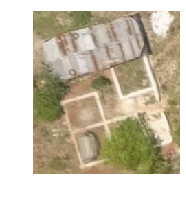

Complete category confidence: 0.9928508996963501


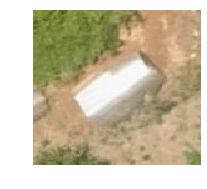

Complete category confidence: 0.9625320434570312


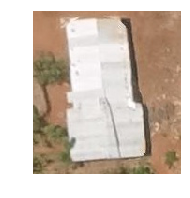

Empty category confidence: 0.9429908394813538


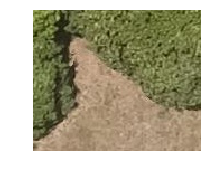

Complete category confidence: 0.9651358723640442


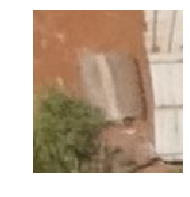

Foundation category confidence: 0.8447896838188171


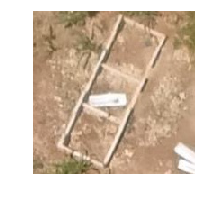

Foundation category confidence: 0.9376210570335388


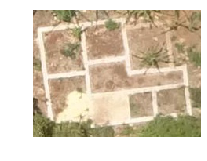

Foundation category confidence: 0.9842356443405151


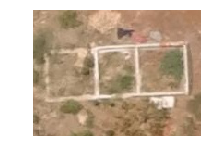

Incomplete category confidence: 0.6751915812492371


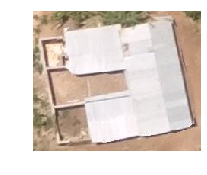

Complete category confidence: 0.9716010093688965


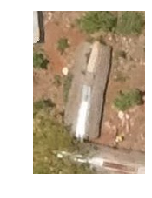

Incomplete category confidence: 0.9374574422836304


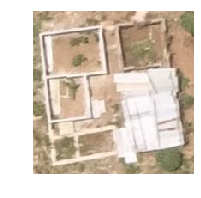

Complete category confidence: 0.9763904809951782


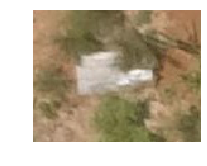

Complete category confidence: 0.9578955173492432


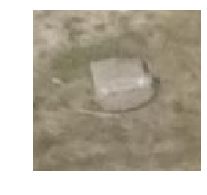

Incomplete category confidence: 0.9578154683113098


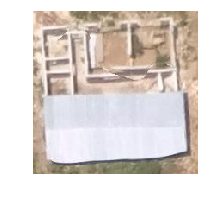

Incomplete category confidence: 0.9233682155609131


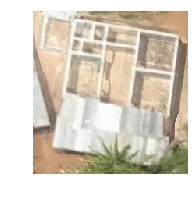

Complete category confidence: 0.7848330736160278


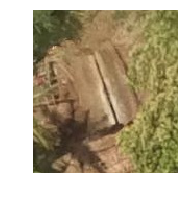

Incomplete category confidence: 0.46774792671203613


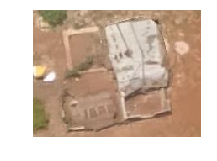

Incomplete category confidence: 0.5261608958244324


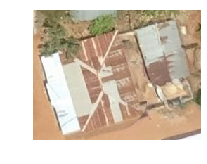

Incomplete category confidence: 0.68595951795578


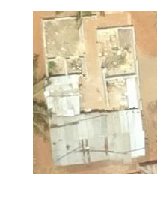

Complete category confidence: 0.9477182030677795


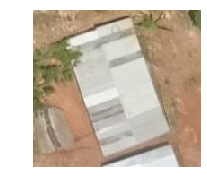

In [32]:
for i in range(30):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], 'category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()

In [33]:
df.to_csv('outputs/20190118_042_preds01.csv',index=False)